In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
import cv2
import mediapipe as mp
import argparse
import os
import json
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

sys.path.append('../')
from util import DatabaseUtil
from util.feature_util import *
from features.body_landmarks import BodyLandmark
from util  import calculate_angle,calculate_bbox,bbox_iou,calculate_distance,calculate_object_center,calculate_line_equation
import pandas as pd
import numpy as np



project_path = '/Users/prasadmaduranga/higher_studies/research/Stroke research/Projects/Staying connected Project/My Projects/stayingconnected_vision_analysis'



def fetch_frame_coordinates(ids):
    """
    Fetches frame coordinates for the given IDs from the database.
    """
    placeholders = ', '.join('?' for _ in ids)  # Create placeholders for parameterized query
    query = f"""
    SELECT id, recording_id, frame_rate, coordinates, coordinates_object1, coordinates_object2
    FROM frame_coordinates
    WHERE id IN ({placeholders});
    """
    db_util = DatabaseUtil()
    return db_util.fetch_data(query, ids)

def transform_data_to_dataframe(data):
    expanded_data = []
    for record in data:
        frame_coordinate_id, recording_id, frame_rate, coordinates_json, coordinates_object1_json, coordinates_object2_json = record
        coordinates = json.loads(coordinates_json)
        coordinates_object1 = json.loads(coordinates_object1_json)
        coordinates_object2 = json.loads(coordinates_object2_json)

        for frame_seq_number, frame_coordinates in enumerate(coordinates):
            frame_data = {
                'frame_coordinate_id': frame_coordinate_id,
                'recording_id': recording_id,
                'frame_rate': frame_rate,
                'frame_seq_number': frame_seq_number,
            }
            for landmark in BodyLandmark:
                if landmark.value < len(frame_coordinates) and frame_coordinates[landmark.value] is not None:
                    frame_data[f'{landmark.name}_X'] = frame_coordinates[landmark.value].get('x')
                    frame_data[f'{landmark.name}_Y'] = frame_coordinates[landmark.value].get('y')
                    frame_data[f'{landmark.name}_Z'] = frame_coordinates[landmark.value].get('z')
                else:
                    frame_data[f'{landmark.name}_X'] = None
                    frame_data[f'{landmark.name}_Y'] = None
                    frame_data[f'{landmark.name}_Z'] = None

            # Process object 1 and 2 coordinates for the frame, if presents
            for obj_index, obj_coordinates in enumerate([coordinates_object1, coordinates_object2], start=1):
                if frame_seq_number < len(obj_coordinates):
                    obj_data = obj_coordinates[frame_seq_number]

                    try:
                        if obj_data[0] is None:
                            for coord in ['x1', 'y1', 'x2', 'y2']:
                                frame_data[f'object_{obj_index}_{coord}'] = None
                            continue

                        frame_data[f'object_{obj_index}_x1'] = obj_data[0]['x']
                        frame_data[f'object_{obj_index}_y1'] = obj_data[0]['y']
                        frame_data[f'object_{obj_index}_x2'] = obj_data[1]['x']
                        frame_data[f'object_{obj_index}_y2'] = obj_data[1]['y']
                    except Exception as e:
                        print(f'Error processing object {obj_index} coordinates for frame {frame_seq_number} in recording {recording_id}.');

                else:
                    for coord in ['x1', 'y1', 'x2', 'y2']:
                        frame_data[f'object_{obj_index}_{coord}'] = None

            expanded_data.append(frame_data)

    df = pd.DataFrame(expanded_data)
    return df




2024-04-11 17:31:14.080449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/prasadmaduranga/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Database connection successful.
Database connection successful.


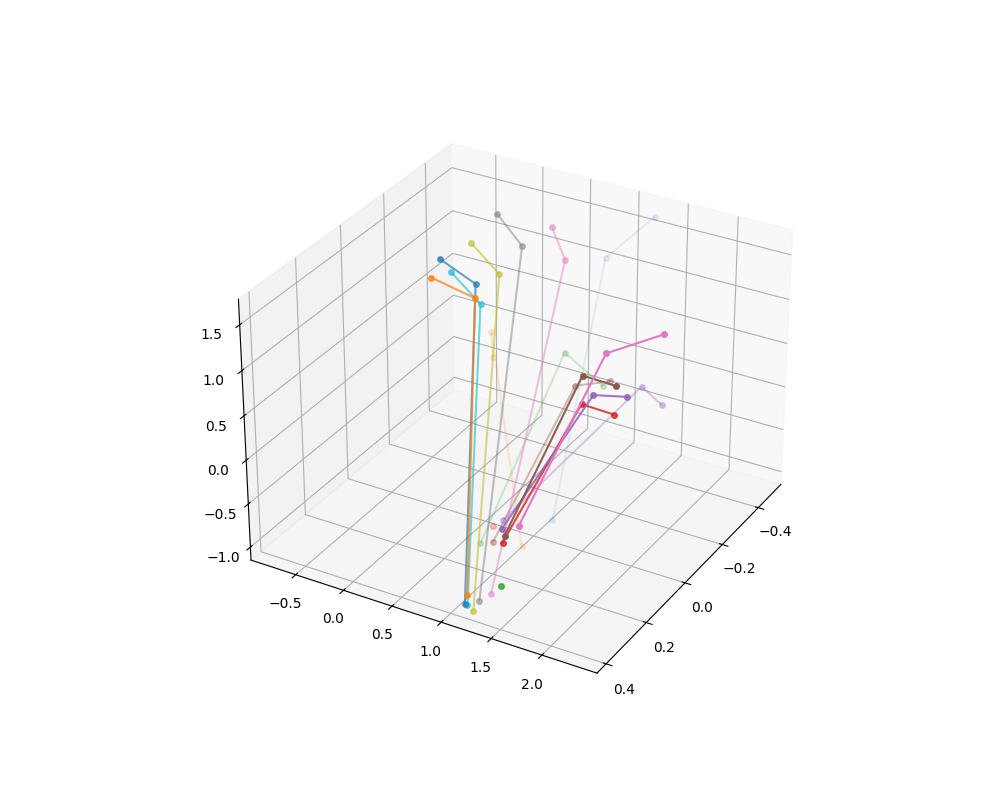

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Assuming df and landmarks are defined
# landmarks = ['RIGHT_ELBOW', 'RIGHT_WRIST', 'RIGHT_MIDDLE_FINGER_MCP']

def plot_opacity_time_series_contours(elev=30, azim=30):
    # Initialize 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique frame sequence numbers
    unique_frames = df['frame_seq_number'].unique()
    # Select every fourth frame for reduced dataset
    reduced_frames = unique_frames[::10]

    # Calculate the range for alpha values (opacity)
    alpha_start = 0.1  # Starting opacity
    alpha_end = 1.0    # Ending opacity
    alpha_range = np.linspace(alpha_start, alpha_end, len(reduced_frames))

    # Iterate over each selected frame sequence number with corresponding alpha value
    for frame_seq_number, alpha in zip(reduced_frames, alpha_range):
        frame_df = df[df['frame_seq_number'] == frame_seq_number]

        # Initialize arrays to hold all coordinates for this frame
        all_x = []
        all_y = []
        all_z = []

        # Collect coordinates for all landmarks in this frame
        for landmark in landmarks:
            x = frame_df[f'{landmark}_X'].dropna().values
            y = frame_df[f'{landmark}_Y'].dropna().values
            z = frame_df[f'{landmark}_Z'].dropna().values
            
            if len(x) > 0:  # Check if there are values
                all_x.append(x[0])
                all_y.append(y[0])
                all_z.append(z[0])

        # Plot a line connecting all landmarks for this frame with varying opacity
        if len(all_x) > 0:  # Ensure there are values before plotting
            ax.plot(all_x, all_y, all_z, '-o', markersize=4, alpha=alpha)

    ax.view_init(elev=elev, azim=azim)
    plt.show()

plot_opacity_time_series_contours()


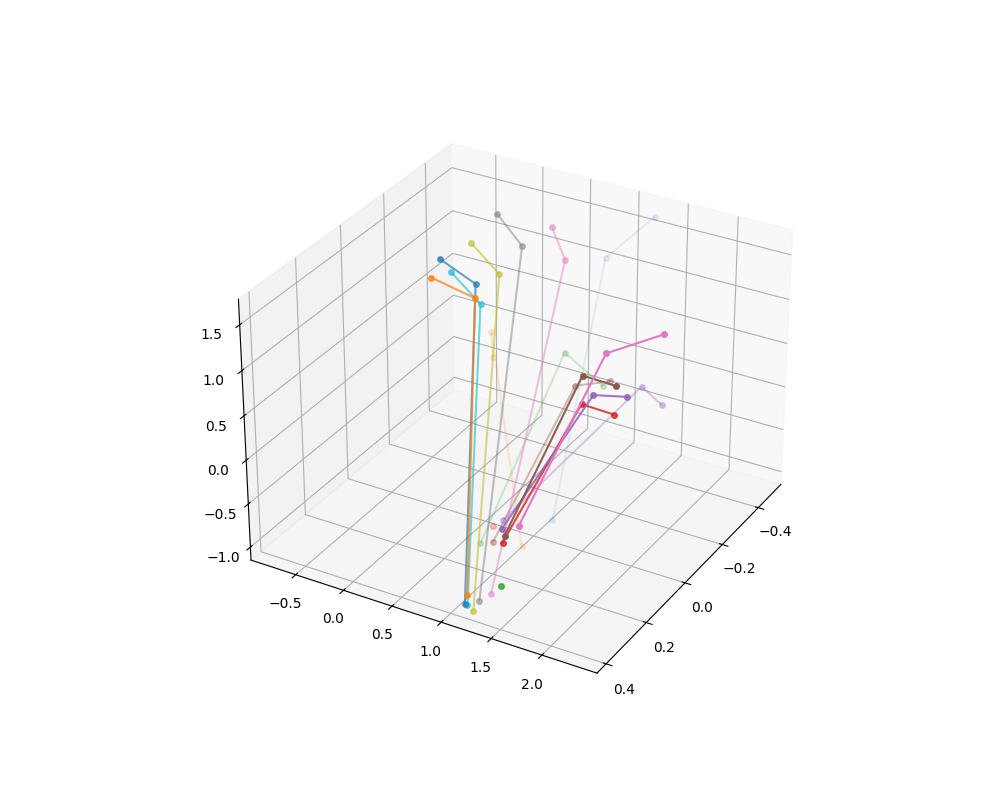

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Assuming df and landmarks are defined
# landmarks = ['RIGHT_ELBOW', 'RIGHT_WRIST', 'RIGHT_MIDDLE_FINGER_MCP']

def plot_opacity_time_series_contours(elev=30, azim=30, frame_no=None):
    # Initialize 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if frame_no is not None:
        # If a specific frame number is provided, plot only that frame
        frame_df = df[df['frame_seq_number'] == frame_no]
        x_vals, y_vals, z_vals = [], [], []  # Lists to store coordinates of all landmarks for connecting them

        for landmark in landmarks:
            x = frame_df[f'{landmark}_X'].dropna().values
            y = frame_df[f'{landmark}_Y'].dropna().values
            z = frame_df[f'{landmark}_Z'].dropna().values

            if len(x) > 0 and len(y) > 0 and len(z) > 0:  # Check if there are values
                x_vals.append(x[0])
                y_vals.append(y[0])
                z_vals.append(z[0])
                ax.scatter(x, y, z, s=100, label=landmark)  # Plot individual landmarks

        # After plotting points, connect them with lines
        if len(x_vals) > 1:  # Ensure there are enough points to connect
            ax.plot(x_vals, y_vals, z_vals, '-o', markersize=4, label='Path')

        ax.legend()

    else:
        # Plot the series with varying opacity
        unique_frames = df['frame_seq_number'].unique()
        reduced_frames = unique_frames[::10]

        alpha_start = 0.1  # Starting opacity
        alpha_end = 1.0    # Ending opacity
        alpha_range = np.linspace(alpha_start, alpha_end, len(reduced_frames))

        for frame_seq_number, alpha in zip(reduced_frames, alpha_range):
            frame_df = df[df['frame_seq_number'] == frame_seq_number]

            all_x = []
            all_y = []
            all_z = []

            for landmark in landmarks:
                x = frame_df[f'{landmark}_X'].dropna().values
                y = frame_df[f'{landmark}_Y'].dropna().values
                z = frame_df[f'{landmark}_Z'].dropna().values

                if len(x) > 0:  # Check if there are values
                    all_x.append(x[0])
                    all_y.append(y[0])
                    all_z.append(z[0])

            if len(all_x) > 0:  # Ensure there are values before plotting
                ax.plot(all_x, all_y, all_z, '-o', markersize=4, alpha=alpha)

    ax.view_init(elev=elev, azim=azim)
    plt.show()

       # To plot the series with varying opacity


In [25]:
db_util = DatabaseUtil()
landmarks =['RIGHT_ELBOW','RIGHT_WRIST','RIGHT_MIDDLE_FINGER_MCP']

# Convert list of IDs from argparse to a tuple, as pyodbc expects a tuple for parameterized queries
frame_coordinate_entry_ids = [1020]

# Fetch frame coordinates data
frame_coordinates_data = fetch_frame_coordinates(frame_coordinate_entry_ids)

df = transform_data_to_dataframe(frame_coordinates_data)
     


Database connection successful.
Database connection successful.


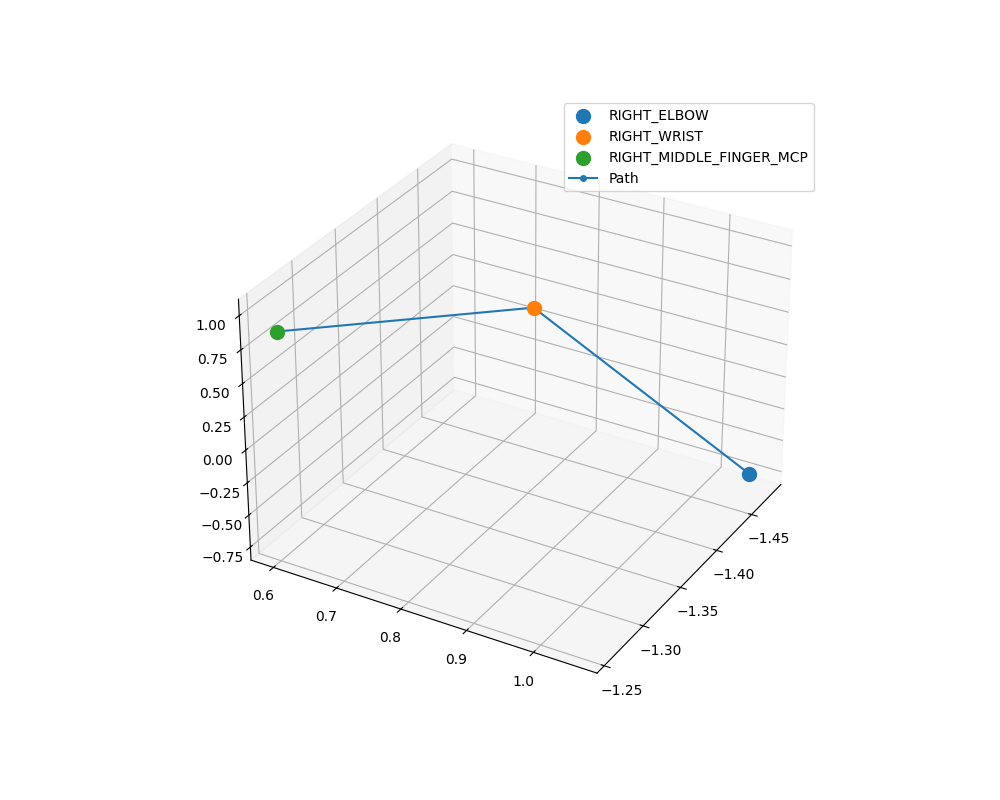

In [27]:

# Example usage:
plot_opacity_time_series_contours(frame_no=70)  # To plot a specific frame
# plot_opacity_time_series_contours() 